In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

In [3]:
DE_genes_pME=pd.read_csv('DEGs_TPMs_pre_ME.csv', index_col=0)
DE_genes_hipsci=pd.read_csv('SVM_pm1k_clean/DEGs_TPMs.csv', index_col=0)

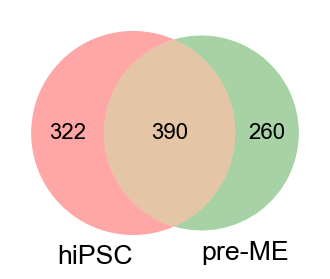

In [5]:
#Script to produce Supplementary Fig. 8A

from matplotlib import rcParams
from matplotlib import rc
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

from matplotlib_venn import venn2

inter=sum(DE_genes_pME.geneid.isin(DE_genes_hipsci.geneid))
plt.figure(figsize=(4,4))
venn2(subsets = (len(DE_genes_hipsci.geneid)-inter, len(DE_genes_pME.geneid)-inter, inter), set_labels = ('hiPSC', 'pre-ME'), alpha = 0.35)

plt.savefig("SFig8A.png", format='png', dpi=300)


In [8]:
# Bootstrapping SVM prediction based on hiPSC chromatin and pre-ME RNA
# to predict further pre-ME RNA from hiPSC chromatin.

import main_funcs
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

#Load from file and preparing the data for the SVM
#Note that only transcription was taken in pre-ME, the rest are values for iPSCs evaluated at genes that were
#DEG in pre-ME.
lines = ["Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"]

intensities_K4 = pd.read_csv('DEG_scores_pMEgenes/DE_genes_K4me3_geneSVM10_pME.csv')
intensities_K4_tx = pd.read_csv('DEG_scores_pMEgenes/DE_genes_K4me3_tx_pm1kSVM10_pME.csv')
intensities_K4_promoters = pd.read_csv('DEG_scores_pMEgenes/DE_genes_K4me3_prompm1kSVM10_pME.csv')
intensities_K4_pm1k = np.maximum(intensities_K4_tx, intensities_K4_promoters)
intensities_K4 = np.maximum(intensities_K4, intensities_K4_pm1k)
intensities_K4 = pd.DataFrame(intensities_K4, columns=intensities_K4.columns, index=intensities_K4.index)
    
intensities_K9 = pd.read_csv('DEG_scores_pMEgenes/DE_genes_K9me3_geneSVM10_pME.csv')
    
intensities_K27 = pd.read_csv('DEG_scores_pMEgenes/DE_genes_K27me3_geneSVM10_pME.csv')
    
intensities_ATAC = pd.read_csv('DEG_scores_pMEgenes/DE_genes_ATAC_geneSVM10_pME.csv')
intensities_ATAC_tx = pd.read_csv('DEG_scores_pMEgenes/DE_genes_ATAC_tx_pm1kSVM10_pME.csv')
intensities_ATAC_promoters = pd.read_csv('DEG_scores_pMEgenes/DE_genes_ATAC_prompm1kSVM10_pME.csv')
intensities_ATAC_pm1k = np.maximum(intensities_ATAC_tx, intensities_ATAC_promoters)
intensities_ATAC = np.maximum(intensities_ATAC, intensities_ATAC_pm1k)
intensities_ATAC = pd.DataFrame(intensities_ATAC, columns=intensities_ATAC.columns, index=intensities_ATAC.index)


epig_vars=['K4', 'K9', 'K27', 'ATAC']

n_boots=10 #1000 for the results presented in the paper.
accuracy=np.zeros([10,n_boots])
aucs=np.zeros([10,n_boots])

#Seed initialisation for Bootstrap
np.random.seed(34601)

n_train=9 #9 datapoints in training set
#Cycle over all cell lines to test all of them from the other 9
tline=0
for test_line in lines:
    #Binarise transcription for the training data and assign a binarisation to the test data (ground truth).
    training_lines=lines.copy()
    training_lines.remove(test_line)
    for s in range(n_boots):
        #Bootstrap. Sample with replacement trining set.
        rvect=np.random.choice(9, 9, replace=True)
        boots_lines=[training_lines[i] for i in rvect]
        i=0
        boots_cols=[None] * n_train
        for line in boots_lines:
            if boots_lines[0:i].count(line)>0:
                boots_cols[i]=boots_lines[i]+"_"+str(boots_lines[0:i].count(line))
            else:
                boots_cols[i]=boots_lines[i]
            i+=1
        DE_boots=pd.DataFrame(data=DE_genes_pME['geneid'])
        for l in range(n_train):
            DE_boots[boots_cols[l]]=DE_genes_pME[boots_lines[l]]
        DE_boots[test_line]=DE_genes_pME[test_line]
        
        #Exclude genes with all zeros (TPM=0 in the training dataset.
        zero_genes=[]
        for gene in DE_genes_pME['geneid']:
            if DE_boots[boots_cols][DE_boots.geneid==gene].sum(axis=1).values[0]==0:
                zero_genes.append(gene)
        DE_boots=DE_boots[~DE_boots.geneid.isin(zero_genes)]
        DE_boots=DE_boots.reset_index(drop=True)
        #Feed the bootstrapping sample
        DE_bin_train, test_ground_truth=main_funcs.binarize_test(DE_boots,boots_cols, test_line)

        vars = pd.DataFrame(columns=['geneid', 'line', 'K4', 'K9', 'K27', 'ATAC', 'expression'])
        for l in range(n_train):
            for gene in DE_bin_train['geneid']:
                vars.loc[len(vars)] = [gene, line, intensities_K4.loc[intensities_K4['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_K9.loc[intensities_K9['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_K27.loc[intensities_K27['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, boots_lines[l]].values[0], 
                                       DE_bin_train.loc[DE_bin_train['geneid'] == gene, boots_cols[l] + '_binary'].values[0]]

        genes_test=pd.DataFrame(columns=['geneid', 'test_line', 'K4', 'K9', 'K27', 'ATAC'])
        for gene in DE_bin_train['geneid']:
            genes_test.loc[len(genes_test)] = [gene, test_line,
                                        intensities_K4.loc[intensities_K4['geneid'] == gene, test_line].values[0], 
                                        intensities_K9.loc[intensities_K9['geneid'] == gene, test_line].values[0], 
                                        intensities_K27.loc[intensities_K27['geneid'] == gene, test_line].values[0], 
                                        intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, test_line].values[0]]
        #SVM for prediction
        probs_prediction, prediction=main_funcs.SVM_prediction(DE_bin_train['geneid'], vars, genes_test, epig_vars)
        #ROC curve 
        tgt=test_ground_truth.transcription.to_numpy(dtype=bool)
        fpr, tpr, thres=roc_curve(tgt,probs_prediction)

        #General accuracy
        accuracy[tline,s]=sum(test_ground_truth.transcription.to_numpy(dtype=bool)==prediction)/len(DE_bin_train['geneid'])
        aucs[tline,s]=auc(fpr,tpr)
    tline+=1
    print(test_line)
    
np.savetxt('accuracy_svm_pME_boots_10.csv', accuracy, delimiter=",")
np.savetxt('auc_svm_pME_boots_10.csv', aucs, delimiter=",")

Bima1
Kolf2
Kolf3
Kucg2
Letw5
Podx1
Qolg1
Sojd3
Wibj2
Yoch6


In [9]:
acc_hipsci=np.genfromtxt("auc_svm_boots_10.csv", delimiter=',')
acc_pME=np.genfromtxt("auc_svm_pME_boots_10.csv", delimiter=',')

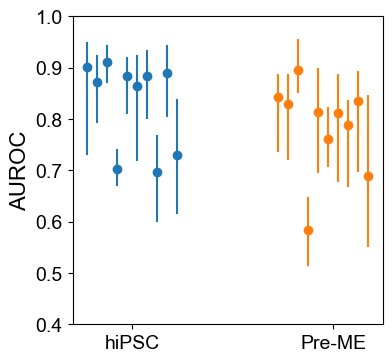

In [10]:
#Script for Supplementary Fig 8D.

acclow=[]
acchigh=[]
accmeans=[]
acclow_log=[]
acchigh_log=[]
accmeans_log=[]
for i in range(len(lines)):
    accmeans.append(np.mean(acc_hipsci[i,:]))
    acchigh.append(np.quantile(acc_hipsci[i,:], 0.975))
    acclow.append(np.quantile(acc_hipsci[i,:], 0.025))
    accmeans_log.append(np.mean(acc_pME[i,:]))
    acchigh_log.append(np.quantile(acc_pME[i,:], 0.975))
    acclow_log.append(np.quantile(acc_pME[i,:], 0.025))

import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
from matplotlib import rcParams
from matplotlib import rc

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

fig, axs = plt.subplots(figsize=(4, 4))

x=np.arange(2)
# plot violin plot
lowerr=np.array(accmeans)-np.array(acclow)
higherr=np.array(acchigh)-np.array(accmeans)
lowerr_log=np.array(accmeans_log)-np.array(acclow_log)
higherr_log=np.array(acchigh_log)-np.array(accmeans_log)
axs.errorbar(np.arange(10)*0.05-0.225,accmeans,yerr=[lowerr, higherr], fmt='o')
axs.errorbar(np.arange(10)*0.05+0.725,accmeans_log,yerr=[lowerr_log, higherr_log], fmt='o')
axs.set_ylim([0.4,1])
#axs.axhline(0.0, linestyle='--', color='gray')
axs.set_xticks(x, ["hiPSC","Pre-ME"])
axs.set_ylabel("AUROC")
plt.savefig("Fig_S8D.png", format='png',bbox_inches='tight', dpi=300)

In [14]:
genes_test

0      ENSG00000003400
1      ENSG00000003436
2      ENSG00000004776
3      ENSG00000004948
4      ENSG00000006016
            ...       
645    ENSG00000280143
646    ENSG00000283128
647    ENSG00000283526
648    ENSG00000283930
649    ENSG00000284874
Name: geneid, Length: 650, dtype: object

In [15]:
#Performance of the SVM on hiPSC chromatin but pre-ME RNA, without bootstrapping
import sklearn

lines = ["Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"]

epig_vars=['K4', 'K9', 'K27', 'ATAC']

#Seed initialisation for Kmeans
np.random.seed(34601)

#Cycle over all cell lines to test all of them from the other 9
for test_line in lines:
    #Binarise transcription for the training data and assign a binarisation to the test data (ground truth).
    training_lines=lines.copy()
    training_lines.remove(test_line)
    DE_bin_train, test_ground_truth=main_funcs.binarize_test(DE_genes_pME,training_lines, test_line)
    genes_test=DE_bin_train['geneid']

    vars = pd.DataFrame(columns=['geneid', 'line', 'K4', 'K9', 'K27', 'ATAC', 'expression'])
    for line in training_lines:
        for gene in DE_bin_train['geneid']:
            vars.loc[len(vars)] = [gene, line, intensities_K4.loc[intensities_K4['geneid'] == gene, line].values[0], 
                                   intensities_K9.loc[intensities_K9['geneid'] == gene, line].values[0], 
                                   intensities_K27.loc[intensities_K27['geneid'] == gene, line].values[0], 
                                   intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, line].values[0], 
                                   DE_bin_train.loc[DE_bin_train['geneid'] == gene, line + '_binary'].values[0]]

    genes_test=pd.DataFrame(columns=['geneid', 'test_line', 'K4', 'K9', 'K27', 'ATAC'])
    for gene in DE_bin_train['geneid']:
        genes_test.loc[len(genes_test)] = [gene, test_line,
                                intensities_K4.loc[intensities_K4['geneid'] == gene, test_line].values[0], 
                                intensities_K9.loc[intensities_K9['geneid'] == gene, test_line].values[0], 
                                intensities_K27.loc[intensities_K27['geneid'] == gene, test_line].values[0], 
                                intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, test_line].values[0]]

    #SVM for prediction
    probs_prediction, prediction=main_funcs.SVM_prediction(DE_bin_train['geneid'], 
                                                           vars, genes_test, epig_vars)
    #ROC curve and save to file
    tgt=test_ground_truth.transcription.to_numpy(dtype=bool)
    fpr, tpr, thres=sklearn.metrics.roc_curve(tgt,probs_prediction)
    filename="AUCs/"+test_line+"_svm_pmeso_auc.csv"
    np.savetxt(filename, np.vstack((fpr, tpr)).T, delimiter=",")

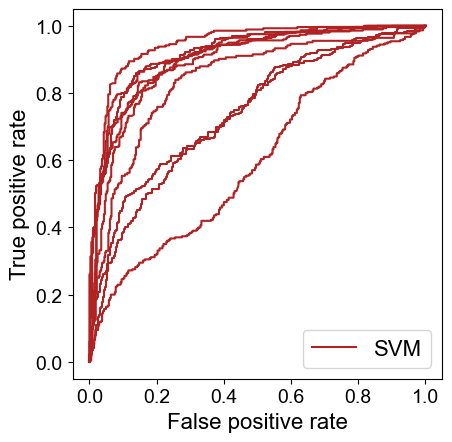

In [18]:
#Script for Figure 8D

import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
from matplotlib import rcParams
from matplotlib import rc

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

#Produce the ROC curves.
AUC_meso=np.zeros(len(lines))
fig, ax=plt.subplots()
ax.set_aspect('equal')
i=0
for test_line in lines:
    filename="AUCs/"+test_line+"_svm_pmeso_auc.csv"
    data=np.genfromtxt(filename, delimiter=",")
    if test_line=='Bima1':
        ax.plot(np.transpose(data)[0],np.transpose(data)[1], color='firebrick', label='SVM')
    else:
        ax.plot(np.transpose(data)[0],np.transpose(data)[1], color='firebrick')
    AUC_meso[i]=auc(np.transpose(data)[0],np.transpose(data)[1])
    i+=1
ax.legend()
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
plt.savefig("Fig_S8C.png", format='png',bbox_inches='tight', dpi=300)

In [41]:
#Preparing pre-ME data according to the hiPSC DEG SVM clusters

clusters=pd.read_csv("Supplementary_File_1.csv", index_col=0)
cluster_names=clusters.cluster.value_counts().index.values
TPMs_pre_ME=pd.read_csv('TPMS_pre-meso.csv')
clusters=clusters.rename(columns={"gene_id":"geneid"})

lines = ["Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"]

TPMs = pd.read_csv('TPMS_pre-meso.csv').iloc[:,0:21]
TPMs=TPMs.rename(columns={"Unnamed: 0": "geneid"})

RNA_means=pd.DataFrame(columns=["geneid","Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"])
ind=0
for gene in DE_genes_hipsci.geneid:
    RNA_means.loc[ind,"geneid"]=gene
    for line in lines:
        RNA_means.loc[ind,line]=(TPMs[TPMs.geneid==gene][line+"r1"].values+TPMs[TPMs.geneid==gene][line+"r2"].values)/2
    ind=ind+1

RNA_means

,geneid,Bima1,Kolf2,Kolf3,Kucg2,Letw5,Podx1,Qolg1,Sojd3,Wibj2,Yoch6
0,ENSG00000002587,0.381992214566356,1.72666217272144,1.638363444267485,1.0447067096943745,1.74638564972275,1.052629417487851,2.199645876063185,0.6993251437635385,1.3625267225837199,1.1520232184541555
1,ENSG00000003436,1.883935775500335,0.6385863208092585,0.6040761621646945,2.17417394709049,0.6682684884934185,0.485043622490741,2.15887920438126,1.893036659161155,3.25120012954995,4.29543536046446
2,ENSG00000004948,2.69590132106796,4.54497781587915,2.573890522920915,0.6451516614270755,5.860862430280425,0.4989906253375065,20.41297186185795,0.351849061616609,7.950161109270786,0.388770755169127
3,ENSG00000005421,0.288680983199107,0.21610887938406048,0.1969470581307185,0.0375424629530879,0.4053714203390305,0.1459726029813822,0.603206951314142,0.47922148657841546,0.6894457356949795,0.19318333863578901
4,ENSG00000006016,6.110075040823395,8.339996613668145,7.8022566271828,62.415883428118406,5.472712356893335,9.94102170753405,6.04955955840156,41.800773490023445,10.72551239378944,45.63298985567245
...,...,...,...,...,...,...,...,...,...,...,...
707,ENSG00000278662,1.8613321616884049,1.787983323621475,1.438698551153915,4.0168260564748,4.61937147522892,0.140199994378575,3.486876423793385,3.46278254371133,5.5835766691675595,3.57075443437705
708,ENSG00000279656,10.938257745115951,10.143909958753355,7.8349877705816,0.8021947740773849,0.7075838005657775,12.605993264955476,0.8840321874667865,10.466483680132715,11.64399599096725,4.544800735368045
709,ENSG00000279692,15.7586824817704,13.27973598837485,15.057926196609898,37.812476152769705,14.18444650997409,16.54019216204065,23.12993099519665,32.537316118030404,11.347888604201735,50.049091321904044
710,ENSG00000280143,7.26150291665097,8.067691322878606,6.899688314214529,1.32920252341301,12.48707418138115,5.123026328824865,8.03104350487884,2.429377456908905,10.378944108280699,1.3746744779231501


In [48]:
meso_in_old_DEGs=pd.merge(RNA_means, clusters[['geneid', 'cluster']], on="geneid")

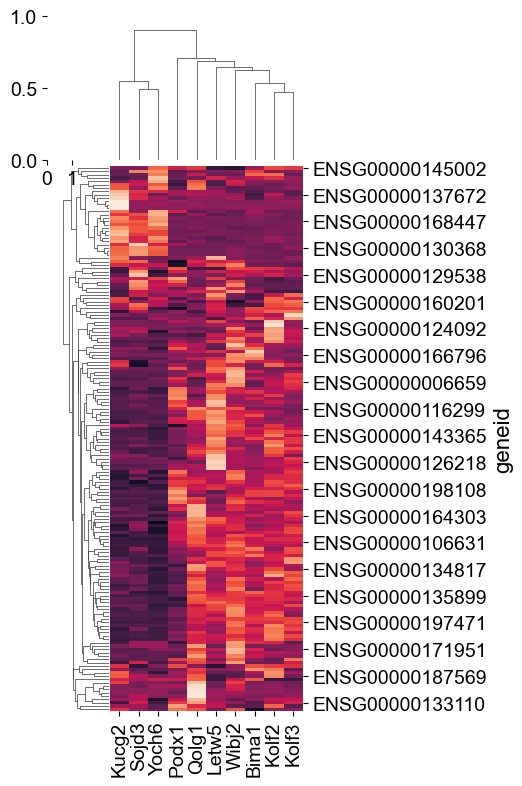

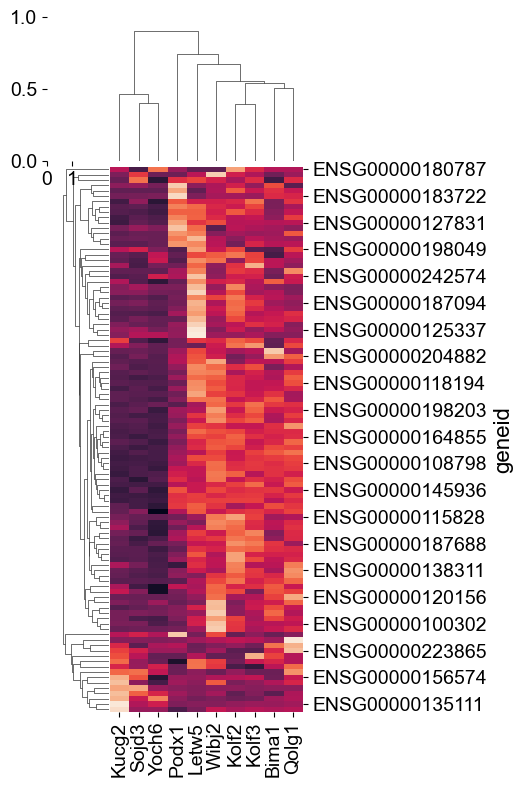

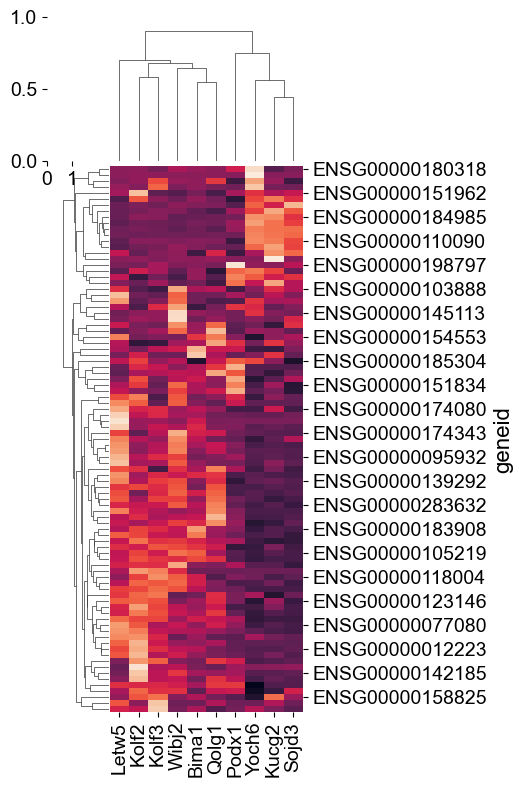

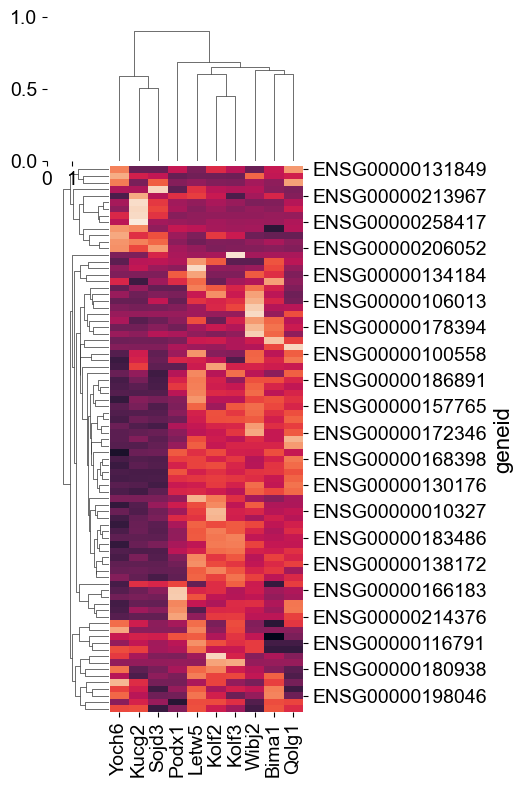

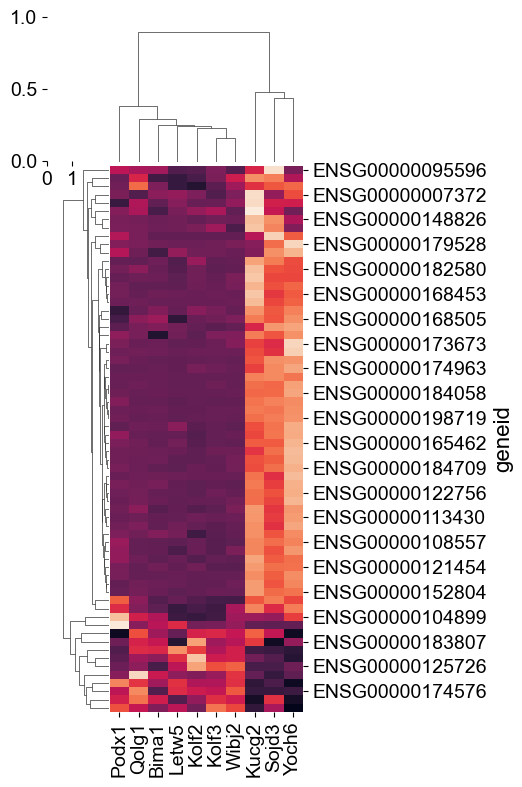

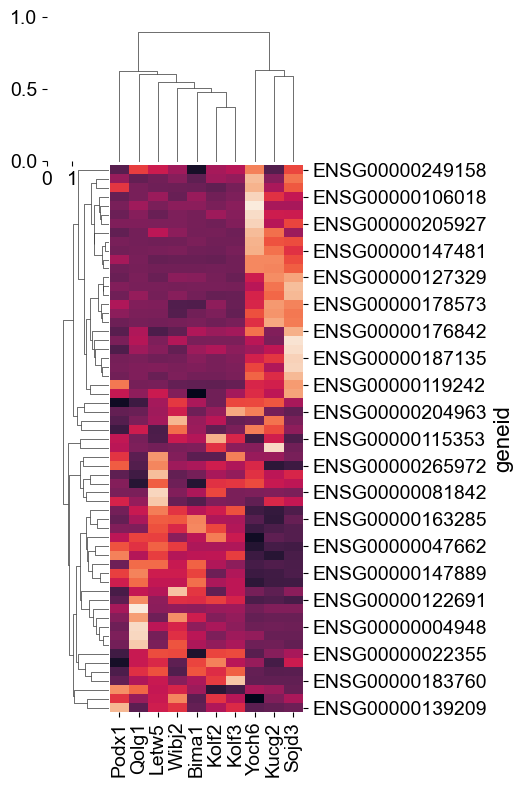

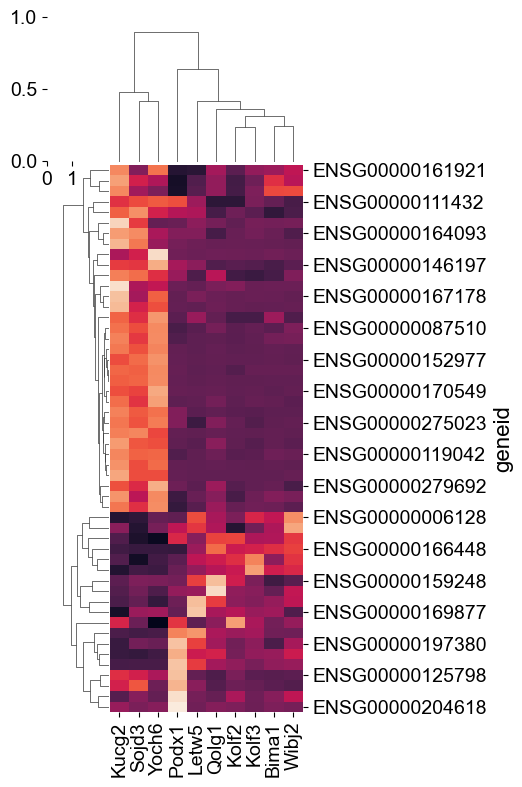

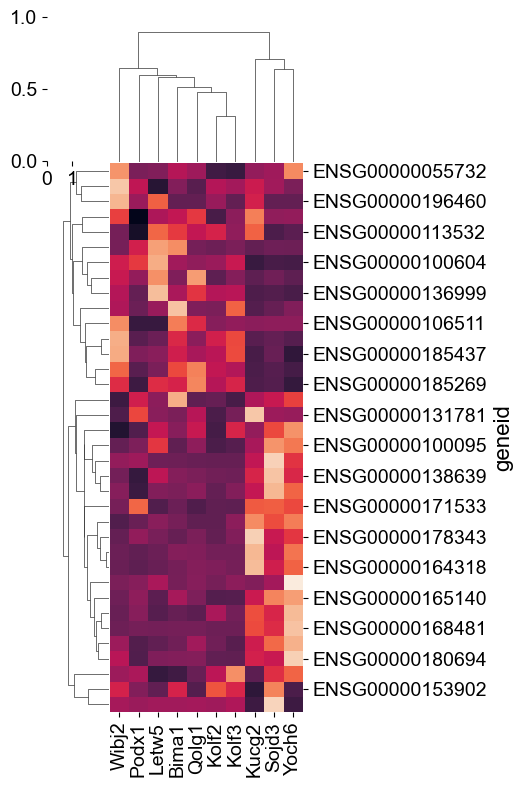

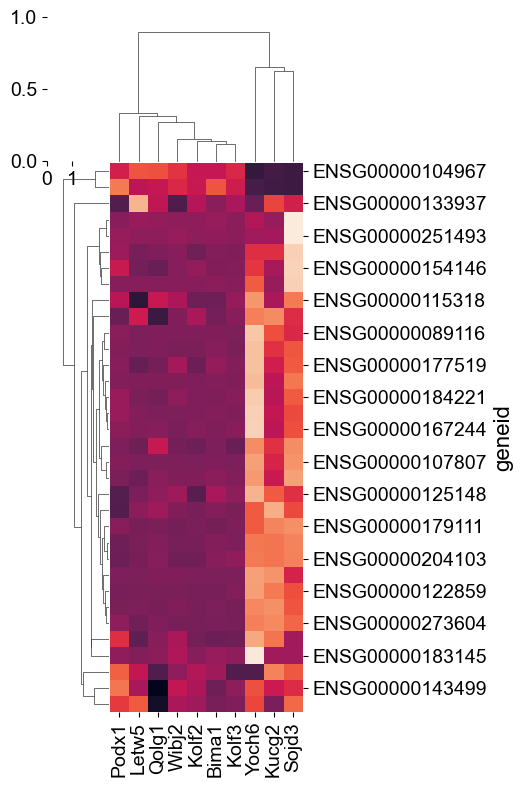

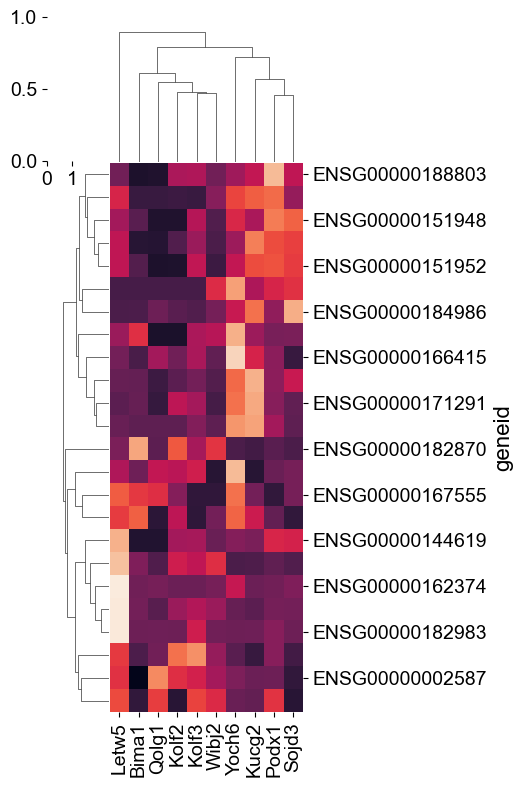

In [52]:
#Obtaining absolute value correlations between expression in pre-ME lines.

import seaborn as sns

abs_corrs=np.zeros([10,45])
idx2=0
for cl in cluster_names:
    cl1=meso_in_old_DEGs.geneid[meso_in_old_DEGs.cluster==cl]
    ipsc_rna_c2=meso_in_old_DEGs[meso_in_old_DEGs.geneid.isin(cl1)].iloc[:,0:11]
    ipsc_rna_c2.index=ipsc_rna_c2.geneid
    ipsc_rna_c2=ipsc_rna_c2.iloc[:,1:].astype(float)
    ipsc_rna_c2=ipsc_rna_c2.drop(ipsc_rna_c2[ipsc_rna_c2.sum(1)==0].index, axis=0)
    cg = sns.clustermap(ipsc_rna_c2, z_score=0, figsize=(5,8), cbar=False, cbar_kws=None)
    zsc_corr=abs(cg.data2d.corr())
    indx=0
    for i in range(10):
        for j in range(i):
            abs_corrs[idx2,indx]=zsc_corr.iloc[i,j]
            indx=indx+1
    idx2=idx2+1

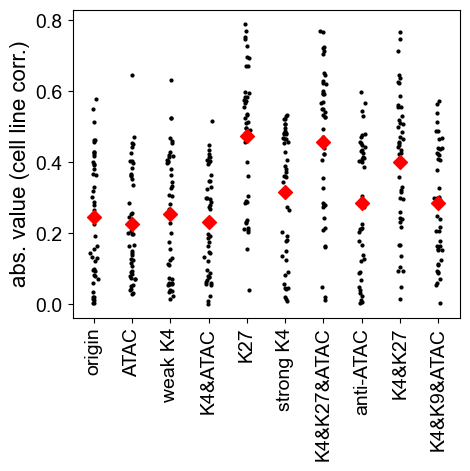

In [53]:
#Script for Supplementary Fig. 8B.

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
xax=np.arange(10)
for i in range(10):
    ax.scatter(xax[i]+np.random.normal(0, 0.04,45), abs_corrs[i], color='black', zorder=2, s=4)
    ax.scatter(xax[i], abs_corrs[i].mean(), color='red', marker="D", zorder=2, s=50)
ax.set_xticks(xax, cluster_names, rotation=90)
ax.set_ylabel("abs. value (cell line corr.)")

plt.savefig("SF8B.png", format='png',bbox_inches='tight', dpi=300)
plt.show()


Text(0.55, 0.84, 'K27')

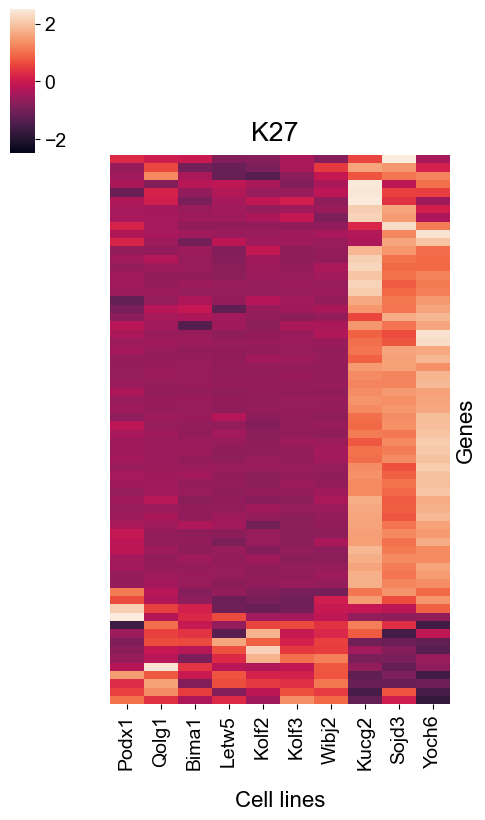

In [56]:
#Script for Fig. 6D. (pre-ME expression in the K27 cluster of genes)

cl1=meso_in_old_DEGs.geneid[meso_in_old_DEGs.cluster=="K27"]
ipsc_rna_c2=meso_in_old_DEGs[meso_in_old_DEGs.geneid.isin(cl1)].iloc[:,0:11]
ipsc_rna_c2.index=ipsc_rna_c2.geneid
ipsc_rna_c2=ipsc_rna_c2.iloc[:,1:].astype(float)
ipsc_rna_c2=ipsc_rna_c2.drop(ipsc_rna_c2[ipsc_rna_c2.sum(1)==0].index, axis=0)
cg = sns.clustermap(ipsc_rna_c2, z_score=0,  yticklabels=False, figsize=(5,8), vmin=-2.5, vmax=2.5)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_ylabel('Genes')
cg.ax_heatmap.set_xlabel('Cell lines', labelpad=15)
cg.fig.suptitle(cluster_names[4], y=0.84, x=0.55)